In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [4]:
BATCH_SIZE=32
IMG_WIDTH = 48
IMG_HEIGHT = 48
KERNEL_SIZE = 4
ENCODING_SIZE=32

In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=42,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size = BATCH_SIZE,
    labels=None,
    color_mode='rgb'
)
train_data = train_data.prefetch(1)

Found 3670 files belonging to 1 classes.


In [6]:
generator = keras.Sequential(
    [
    keras.layers.Dense(256*6*6,activation='selu',input_shape=[ENCODING_SIZE]),
    keras.layers.Reshape([6,6,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=128,kernel_size=KERNEL_SIZE,strides=2,padding='same',activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=64,kernel_size=KERNEL_SIZE,strides=2,padding='same',activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=32,kernel_size=KERNEL_SIZE,strides=2,padding='same',activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Conv2DTranspose(filters=3,kernel_size=KERNEL_SIZE,strides=1,padding='same',activation='selu',kernel_initializer='lecun_normal')
    ]
)

generator.summary()


discriminator =  keras.Sequential(
    [
       keras.layers.Conv2D(32,input_shape=[IMG_WIDTH,IMG_HEIGHT,3],kernel_size=KERNEL_SIZE,strides=1,padding='same',activation=keras.layers.LeakyReLU(0.2)),
       keras.layers.Dropout(0.25),
       keras.layers.Conv2D(64,kernel_size=KERNEL_SIZE,strides=2,padding='same',activation=keras.layers.LeakyReLU(0.2)),
       keras.layers.Dropout(0.25),
       keras.layers.Conv2D(128,kernel_size=KERNEL_SIZE,strides=2,padding='same',activation=keras.layers.LeakyReLU(0.2)),
       keras.layers.Dropout(0.25),
       keras.layers.Conv2D(256,kernel_size=KERNEL_SIZE,strides=2,padding='same',activation=keras.layers.LeakyReLU(0.2)),
       keras.layers.Dropout(0.25),
       keras.layers.Flatten(),
       keras.layers.Dense(1,activation='sigmoid')
    ]
)
discriminator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9216)              304128    
                                                                 
 reshape (Reshape)           (None, 6, 6, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 6, 6, 256)         1024      
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 12, 12, 128)       524416    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 12, 12, 128)       512       
 chNormalization)                                                
                                                        

In [7]:
gan = keras.models.Sequential([generator,discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48, 48, 3)         995811    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 699361    
                                                                 
Total params: 1695172 (6.47 MB)
Trainable params: 1694276 (6.46 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________


In [8]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


In [9]:
def train_gan(gan, dataset, BATCH_SIZE, ENCODING_SIZE, n_epochs = 50, plot_frequency = 10, learning_rate = 0.01):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        preds = []
        actuals = []
        for X_batch in dataset:
          # give some feedback during the epoch
          print("=", end = '')
          X_batch /= 255

          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * len(X_batch) + [[1.]] * len(X_batch))
          y1 += 0.05 * tf.random.uniform(tf.shape(y1)) # add random noise to labels - this seems to help training significantly
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_and_real, y1)

          # capture the actual and predicted values for later
          actuals.extend([y.numpy()[0] for y in y1])
          preds.extend([y[0] for y in discriminator.predict(X_fake_and_real).tolist()])

          # phase 2 - training the generator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          y2 = tf.constant([[1.]] * len(X_batch))
          discriminator.trainable = False
          gan.train_on_batch(noise, y2)
             # print out a confusion matrix to see how the discriminator is doing
        # commented out here to save space
        print()
        print(confusion_matrix([1 if a > 0.5 else 0 for a in actuals],
                               [1 if p > 0.5 else 0 for p in preds]))
        print('accuracy: ', accuracy_score([1 if a > 0.5 else 0 for a in actuals],
                                           [1 if p > 0.5 else 0 for p in preds]))

        # only plot every 10 epochs
        if epoch % plot_frequency == 0:
          plot_multiple_images(X_fake_and_real, 3)
          plt.show()

    plot_multiple_images(X_fake_and_real, 3)
    plt.show()



Epoch 1/51
2/2 [==============================] - 0s 38ms/step



[[2585 1085]
 [ 992 2678]]
accuracy:  0.7170299727520436


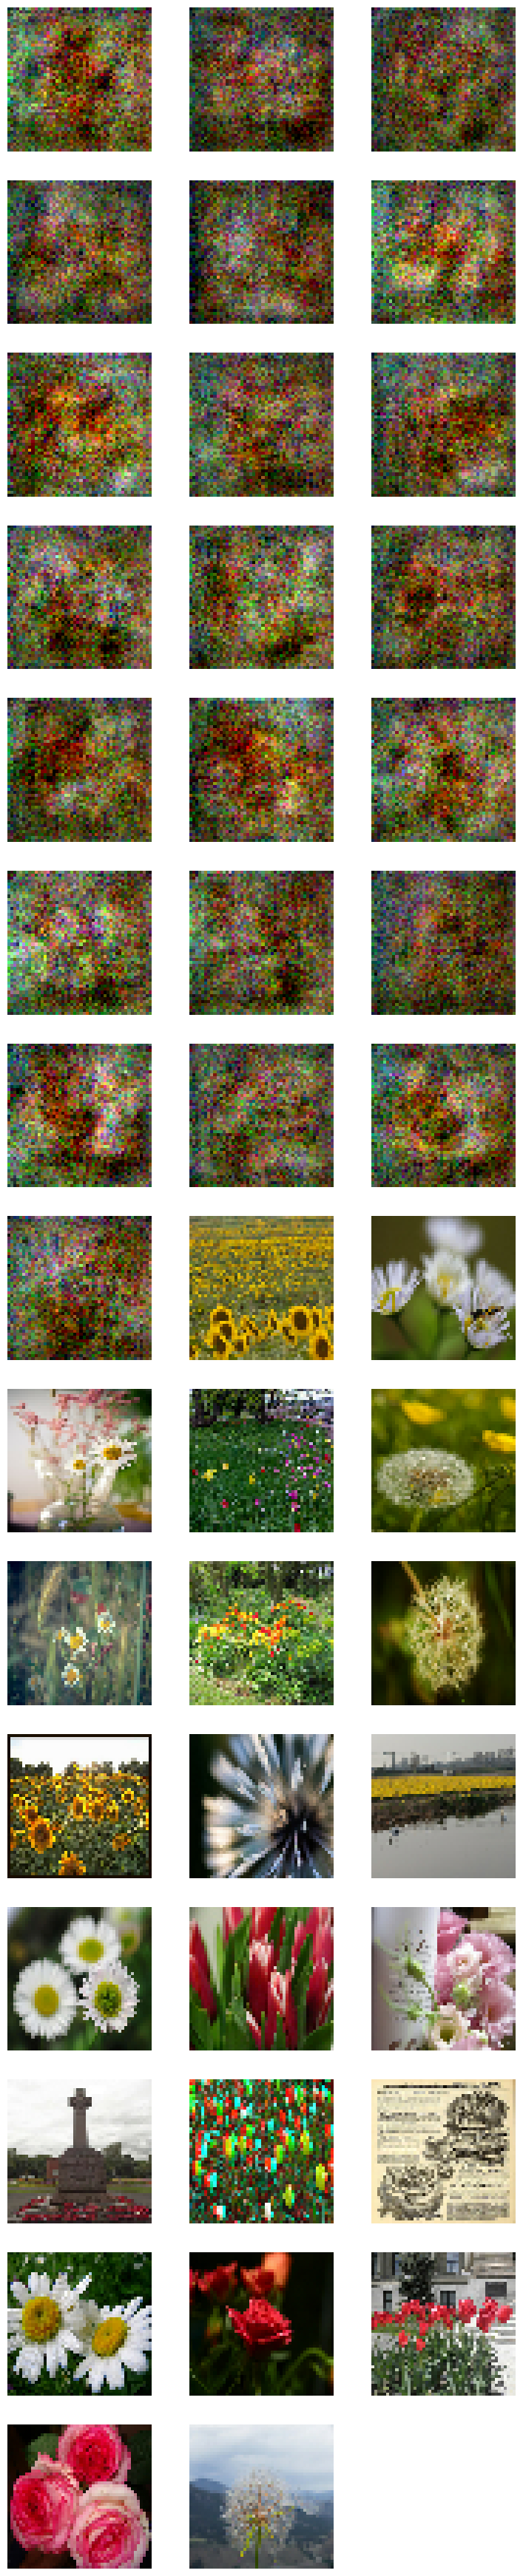

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 49ms/step

[[3316  354]
 [1742 1928]]
accuracy:  0.714441416893733
Epoch 11/51
2/2 [==============================] - 0s 44ms/step

[[3223  447]
 [1661 2009]]
accuracy:  0.7128065395095368
Epoch 12/51
2/2 [==============================] - 0s 54ms/step

[[3366  304]
 [1708 1962]]
accuracy:  0.7258855585831062
Epoch 13/51
2/2 [==============================] - 0s 59ms/step

[[3286  384]
 [1574 2096]]
accuracy:  0.7332425068119891
Epoch 14/51
2/2 [==============================] - 0s 52ms/step

[[3341  329]
 [1421 2249]]
accuracy:  0.7615803814713896
Epoch 15/51
2/2 [==============================] - 0s 71ms/step

[[3386  284]
 [1393 2277]]
accuracy:  0.7715258855585831
Epoch 16/51
2/2 [==============================] - 0s 46ms/step

[[3395  275]
 [1324 2346]]
accuracy:  0.7821525885558583
Epoch 17/51
2/2 [==============================] - 0s 49ms/step

[[3343  327]
 [1346 2324]]
accuracy:  0.772


[[3365  305]
 [ 717 2953]]
accuracy:  0.8607629427792916


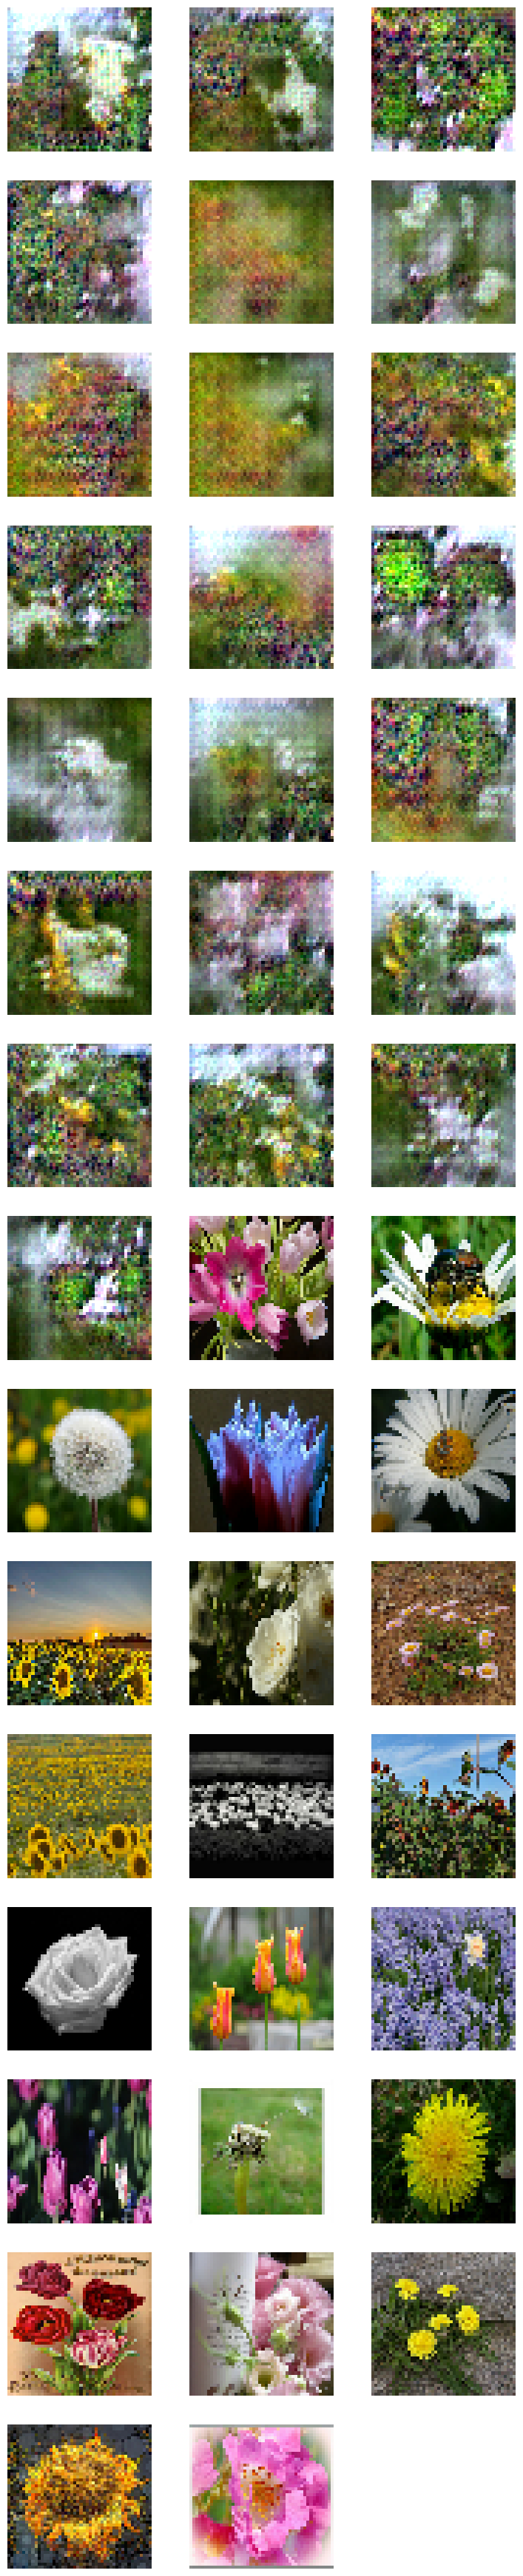

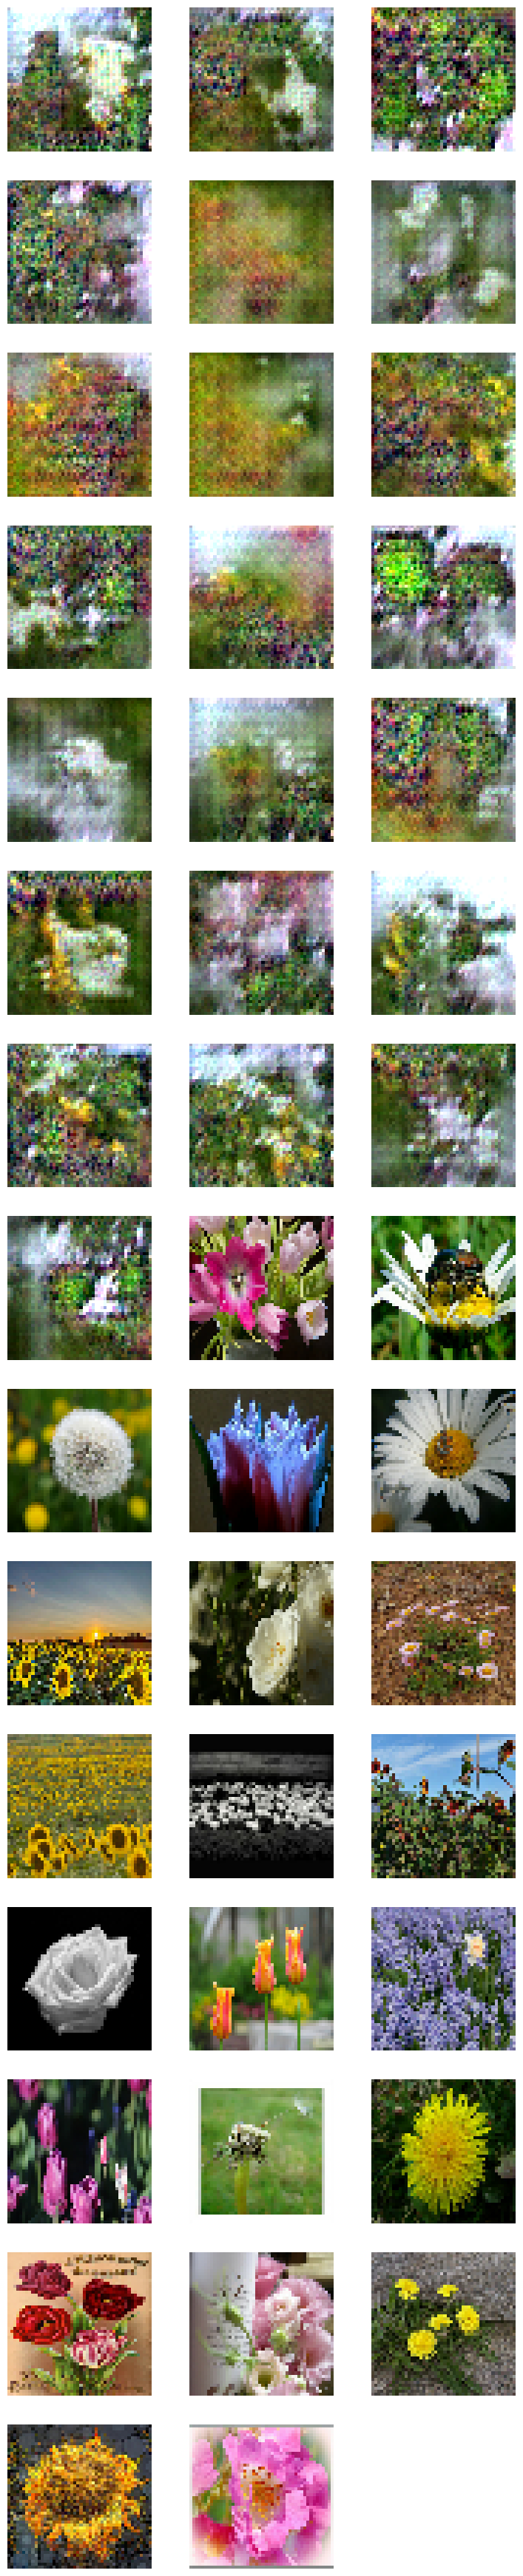

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)

discriminator.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())
discriminator.trainable = False


gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())

train_gan(gan, train_data, BATCH_SIZE, ENCODING_SIZE, n_epochs = 51, plot_frequency = 50)